# Introdution

# Imports

In [2]:
# Standard Python & Data Manipulation
import re
import pandas as pd
import numpy as np
import joblib
from dotenv import load_dotenv
from sqlalchemy import create_engine, text

# Data Science & Scikit-learn
from scipy.signal import find_peaks
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from itertools import combinations

# Deep Learning (PyTorch, FastAI, TSAI)
import torch
from fastai.callback.core import Callback
from fastai.learner import Learner
from tsai.all import * 
from pytorch_lightning.callbacks import EarlyStopping

# Load data from DB

Connects to the database and executes a query to retrieve OHLCV data
joined with technical indicators, filtering for candles where a 'news' signal is set

In [3]:
load_dotenv()

DB_USER = os.getenv("DB_USER", 'root')
DB_PASS = os.getenv("DB_PASS", "")
DB_HOST = os.getenv("DB_HOST", "127.0.0.1")
DB_PORT = os.getenv("DB_PORT", "3306")
DB_NAME = os.getenv("DB_NAME", "market_db")

DATABASE_URL = f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}?charset=utf8mb4"

engine = create_engine(DATABASE_URL, pool_pre_ping=True)

In [4]:
KLINE_TABLE = os.getenv('KLINE_TABLE', 'kline_data')
TI_TABLE = os.getenv('TI_TABLE', 'technical_indicators')
MS_TABLE = os.getenv('MS_TABLE', 'market_sentiment')


CHUNKSIZE = int(os.getenv('CHUNKSIZE', '50000'))
OUTPUT_PARQUET = os.getenv('OUTPUT_PARQUET', 'combined_simple.parquet')

print('DB:', DATABASE_URL)

engine = create_engine(DATABASE_URL, pool_pre_ping=True)
with engine.connect() as conn:
    earliest = conn.execute(text(f"SELECT MIN(publication_time) FROM `{MS_TABLE}`")).scalar()

if earliest is None:
    raise SystemExit('market_sentiment publication_time')

print('Earliest publication_time:', earliest)

sql = f"""
SELECT
k.*,
ti.*,
ms_agg.finbert_score_mean AS finbert_score,
ms_agg.sentiment_score_mean AS sentiment_score,
ms_single.finbert_label AS finbert_label
FROM `{KLINE_TABLE}` k
LEFT JOIN `{TI_TABLE}` ti
ON k.ticker = ti.ticker AND k.candle_time = ti.candle_time
LEFT JOIN (
SELECT ticker, candle_time, AVG(finbert_score) AS finbert_score_mean, AVG(sentiment_score) AS sentiment_score_mean
FROM `{MS_TABLE}`
GROUP BY ticker, candle_time
) ms_agg
ON k.ticker = ms_agg.ticker AND k.candle_time = ms_agg.candle_time
LEFT JOIN (
-- pick one finbert_label per (ticker,candle_time) if exists
SELECT ticker, candle_time, MIN(finbert_label) AS finbert_label
FROM `{MS_TABLE}`
GROUP BY ticker, candle_time
) ms_single
ON k.ticker = ms_single.ticker AND k.candle_time = ms_single.candle_time
WHERE k.candle_time >= :earliest
ORDER BY k.ticker, k.candle_time ASC
"""
print('SQL prepared. Running query...')

chunks = []
with engine.connect() as conn:
    for chunk in pd.read_sql_query(text(sql), conn, params={'earliest': earliest}, chunksize=CHUNKSIZE):
        print('Loaded chunk:', len(chunk))
        chunks.append(chunk)

if not chunks:
    df = pd.DataFrame()
else:
    df = pd.concat(chunks, ignore_index=True)
print('Total rows loaded:', len(df))

if not df.empty:
    df = df.loc[:, ~df.columns.duplicated()]
    df.to_parquet(OUTPUT_PARQUET, index=False, engine='fastparquet')
    print('Saved to', OUTPUT_PARQUET)
else:
    print('No data to save')

df.head()

DB: mysql+pymysql://root:@127.0.0.1:3306/market_db?charset=utf8mb4
Earliest publication_time: 2021-10-12 20:00:00
SQL prepared. Running query...
Loaded chunk: 19624
Total rows loaded: 19624
Saved to combined_simple.parquet


,ticker,candle_time,open,high,low,close,volume,atr14,ema12_cross_ema26_up,ema12_cross_ema26_down,...,macd_cross_signal_up,macd_cross_signal_down,rsi_overbought,rsi_oversold,close_cross_upper_bb,close_cross_lower_bb,strong_trend,finbert_score,sentiment_score,finbert_label
0,BTCUSDT,2021-10-12 20:00:00,55329.78,55600.00,53879.00,55361.08,6566,662.829627,0,0,...,0,0,0,0,0,0,1,NaN,NaN,None
1,BTCUSDT,2021-10-12 21:00:00,55361.08,56093.88,55096.42,56074.08,1832,686.731796,0,0,...,0,0,0,0,0,0,1,NaN,NaN,None
2,BTCUSDT,2021-10-12 22:00:00,56074.09,56420.00,56030.00,56392.95,1875,665.536668,0,0,...,0,0,0,0,0,0,1,NaN,NaN,None
3,BTCUSDT,2021-10-12 23:00:00,56392.95,56548.99,55938.60,55996.93,1398,661.597620,0,0,...,0,0,0,0,0,0,1,NaN,NaN,None
4,BTCUSDT,2021-10-13 00:00:00,55996.91,56520.00,55825.90,56459.81,1774,663.919219,0,0,...,0,0,0,0,0,0,0,NaN,NaN,None


# EDA

In [5]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
candle_time,19624,2022-11-25 15:51:16.620464640,2021-10-12 20:00:00,2022-05-05 05:45:00,2022-11-25 15:30:00,2023-06-18 02:15:00,2024-01-08 12:00:00,NaN
open,19624.0,31393.333103,15648.23,22339.2225,28295.715,39161.5775,68635.12,11665.760955
high,19624.0,31518.409071,15769.99,22405.7775,28398.5,39382.12,69000.0,11725.79922
low,19624.0,31263.989821,15476.0,22228.5425,28183.095,38981.47,68451.19,11600.919948
close,19624.0,31392.76959,15649.52,22339.2225,28295.705,39161.58,68633.69,11664.877473
volume,19624.0,4780.405014,0.0,1060.0,2180.0,6327.25,137207.0,6320.811148
atr14,19624.0,254.602916,21.051903,131.94993,200.533233,338.15479,1481.1497,173.277661
ema12_cross_ema26_up,19624.0,0.018192,0.0,0.0,0.0,0.0,1.0,0.133649
ema12_cross_ema26_down,19624.0,0.018141,0.0,0.0,0.0,0.0,1.0,0.133465
close_cross_sma50_up,19624.0,0.039391,0.0,0.0,0.0,0.0,1.0,0.194527


## Missing values

In [6]:
df.isna().any()

ticker                    False
candle_time               False
open                      False
high                      False
low                       False
close                     False
volume                    False
atr14                     False
ema12_cross_ema26_up      False
ema12_cross_ema26_down    False
close_cross_sma50_up      False
close_cross_sma50_down    False
macd_cross_signal_up      False
macd_cross_signal_down    False
rsi_overbought            False
rsi_oversold              False
close_cross_upper_bb      False
close_cross_lower_bb      False
strong_trend              False
finbert_score              True
sentiment_score            True
finbert_label              True
dtype: bool

## Replace missing values

Signal Persistence Logic

To account for market inertia following an instantaneous indicator signal, we implement a signal persistence mechanism.
1. Propagation: Each active flag (1), interpreted as a market "news" event or strong impulse, is extended across the next 5 periods using a Forward Fill (limit 5).
2. Neutralization: Any remaining gaps after propagation are reset to a neutral state (0).
3. Benefit: This approach smoothes high-frequency noise, allowing the model to focus on the medium-term consequences of key events.

In [7]:
# replace NaNs by forward fill with limit of 5
df['sentiment_score'] = df['sentiment_score'].ffill(limit=5)
df['finbert_score'] = df['finbert_score'].ffill(limit=5)
df['finbert_label'] = df['finbert_label'].ffill(limit=5)

#replace remaining NaNs
df['sentiment_score'].fillna(0, inplace=True)
df['finbert_score'].fillna(0, inplace=True)
df['finbert_label'].fillna('neutral', inplace=True)

df.isna().any()

ticker                    False
candle_time               False
open                      False
high                      False
low                       False
close                     False
volume                    False
atr14                     False
ema12_cross_ema26_up      False
ema12_cross_ema26_down    False
close_cross_sma50_up      False
close_cross_sma50_down    False
macd_cross_signal_up      False
macd_cross_signal_down    False
rsi_overbought            False
rsi_oversold              False
close_cross_upper_bb      False
close_cross_lower_bb      False
strong_trend              False
finbert_score             False
sentiment_score           False
finbert_label             False
dtype: bool

In [8]:
df.finbert_label.value_counts()

finbert_label
neutral     7439
negative    7203
positive    4982
Name: count, dtype: int64

## Data labeling and features engineering

## Calculating technical analysis indicators and label decisions

In [9]:
def calculate_indicators(df):
    
    df = df.copy()

    df['finbert_label'] = df['finbert_label'].apply(lambda x: 1 if x == 'positive' else (-1 if x == 'negative' else 0))
    
    # List of all primary binary columns
    binary_cols = [
        'ema12_cross_ema26_up', 'ema12_cross_ema26_down',
        'close_cross_sma50_up', 'close_cross_sma50_down',
        'macd_cross_signal_up', 'macd_cross_signal_down',
        'rsi_overbought', 'rsi_oversold',
        'close_cross_upper_bb', 'close_cross_lower_bb',
        'strong_trend'
    ]
    
    # List of all columns to KEEP 
    keep_cols = ['open', 'high', 'low', 'close', 'volume', 'atr14', 'finbert_score', 'sentiment_score', 'finbert_label']
    
    # Add all calculated binary and aggregated binary features
    for col in binary_cols:
        keep_cols.append(col)
        # keep_cols.append(f"{col}_any_last3")
        
    # Filter the DataFrame to keep only the necessary columns
    df_final = df[keep_cols].copy()
    
    return df_final

def label_decisions(
    df,
    atr_multiplier_TP=3,
    atr_multiplier_SL=1.5,
    lookahead=3,
    volume_threshold=0.4,
    atr_threshold=0.001,
    volatility_entry_threshold=0.001,  
    min_pct_move=0.01,
    prefer_tp_on_same_bar=False,       
    require_close_confirmation=False,  
    sustain_bars=0                     
):
    """Mark BUY/SELL if TP/SL reached within lookahead OR if price moves by min_pct_move.
    Improved logic: SL that occurs earlier in the lookahead cancels BUY (and vice versa)."""
    df = df.copy()
    df['decision'] = 'HOLD'
    avg_volume = df['volume'].rolling(24).mean()

    n = len(df)
    for i in range(n - lookahead):
        entry_price = df['close'].iloc[i]
        atr = df['atr14'].iloc[i]
        volume = df['volume'].iloc[i]

        # Skip if ATR or volume constraints not satisfied
        if (
            pd.isna(atr) or
            atr / (entry_price + 1e-12) < atr_threshold or
            volume < avg_volume.iloc[i] * volume_threshold or
            atr / (entry_price + 1e-12) < volatility_entry_threshold
        ):
            continue

        tp_buy = entry_price + atr * atr_multiplier_TP
        sl_buy = entry_price - atr * atr_multiplier_SL

        # Scan lookahead for earliest event: SL first -> cancel, TP or min_move first -> BUY
        sl_hit = False
        buy_marked = False

        for j in range(1, lookahead + 1):
            high = df['high'].iloc[i + j]
            low = df['low'].iloc[i + j]
            close = df['close'].iloc[i + j]

            # Determine whether this bar hits TP or SL using chosen confirmation method
            tp_hit = (high >= tp_buy) if not require_close_confirmation else (close >= tp_buy)
            sl_hit_this_bar = (low <= sl_buy) if not require_close_confirmation else (close <= sl_buy)

            # If both hit on same bar — apply tie-breaker
            if tp_hit and sl_hit_this_bar:
                if prefer_tp_on_same_bar:
                    df.at[i, 'decision'] = 'BUY'
                    buy_marked = True
                    break
                else:
                    sl_hit = True
                    break

            # If SL hit on this bar before any TP -> cancel BUY
            if sl_hit_this_bar:
                sl_hit = True
                break

            # If TP or min_pct_move hit before SL -> mark BUY
            pct_move = (high - entry_price) / (entry_price + 1e-12)
            min_move_hit = pct_move >= min_pct_move if not require_close_confirmation else ((close - entry_price) / (entry_price + 1e-12) >= min_pct_move)

            if tp_hit or min_move_hit:
                # sustain check: ensure move holds for sustain_bars (lookahead cannot exceed remaining bars)
                if sustain_bars > 0:
                    ok = True
                    # check next sustain_bars bars (or until lookahead end)
                    max_k = min(lookahead, j + sustain_bars)
                    for k in range(j, max_k + 1):
                        c = df['close'].iloc[i + k]
                        if (tp_hit and c < tp_buy) or (not tp_hit and c < entry_price * (1 + min_pct_move)):
                            ok = False
                            break
                    if not ok:
                        # treat as not confirmed, continue scanning
                        continue

                df.at[i, 'decision'] = 'BUY'
                buy_marked = True
                break

        if buy_marked:
            continue  # go to next i
    return df

In [10]:
df = calculate_indicators(df)
df = label_decisions(df)
df.isna().sum()
df[['decision']].value_counts()
df.head()

,open,high,low,close,volume,atr14,finbert_score,sentiment_score,finbert_label,ema12_cross_ema26_up,...,close_cross_sma50_up,close_cross_sma50_down,macd_cross_signal_up,macd_cross_signal_down,rsi_overbought,rsi_oversold,close_cross_upper_bb,close_cross_lower_bb,strong_trend,decision
0,55329.78,55600.00,53879.00,55361.08,6566,662.829627,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,1,BUY
1,55361.08,56093.88,55096.42,56074.08,1832,686.731796,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,1,HOLD
2,56074.09,56420.00,56030.00,56392.95,1875,665.536668,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,1,HOLD
3,56392.95,56548.99,55938.60,55996.93,1398,661.597620,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,1,BUY
4,55996.91,56520.00,55825.90,56459.81,1774,663.919219,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,HOLD


## Features correlation analysis

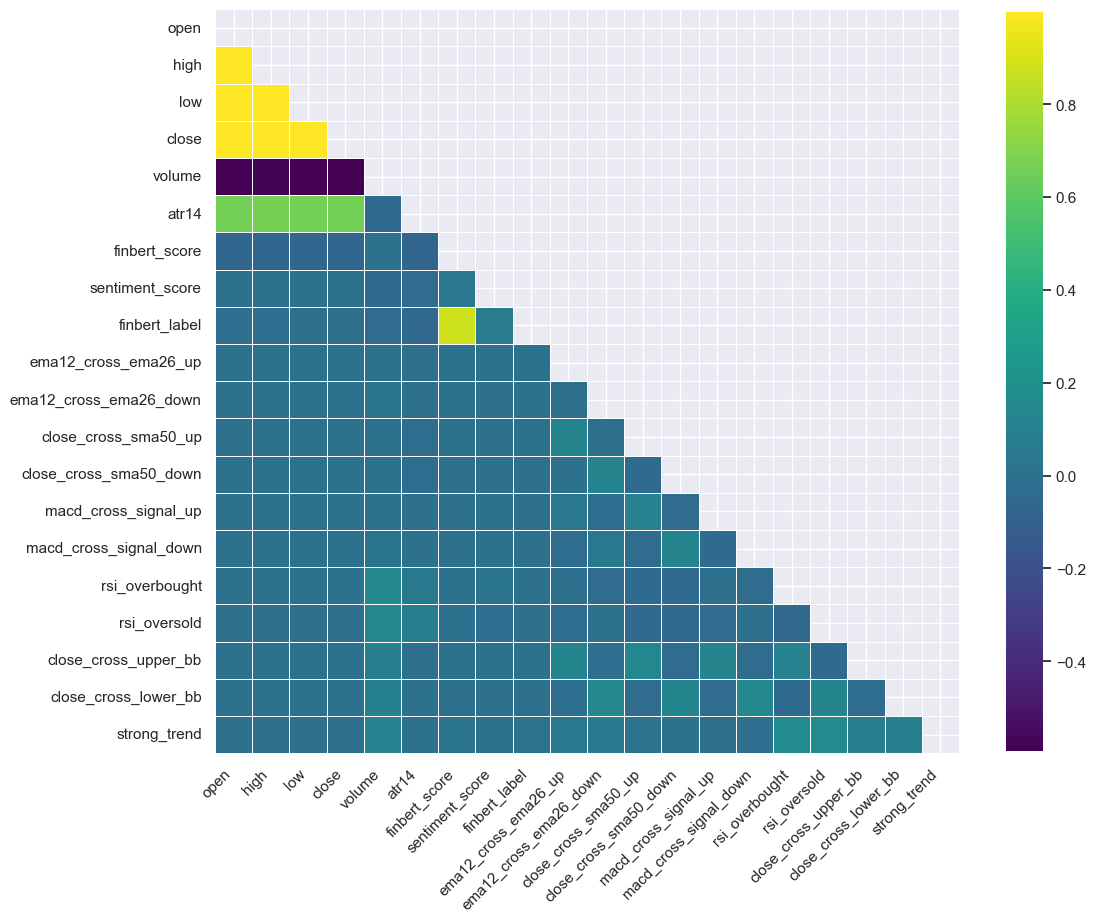

In [11]:
sns.set(font_scale=1.1)
corr_train = df.drop(columns=['decision']).corr(method="spearman")
mask = np.triu(np.ones_like(corr_train, dtype=bool))

sns.set(font_scale=1.0)
plt.figure(figsize=(12, 12))
sns.heatmap(
    corr_train,
    cmap='viridis',
    square=True,
    mask=mask,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

## Corr analysis text interpritation

In [12]:
corr_matrix = df.drop(columns=['decision']).corr(method='spearman')

upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

strong_corr = upper_tri.stack().reset_index()
strong_corr.columns = ['feature_1', 'feature_2', 'spearman_corr']
strong_corr = strong_corr[strong_corr['spearman_corr'].abs() > 0.7]

strong_corr = strong_corr.reindex(strong_corr['spearman_corr'].abs().sort_values(ascending=False).index)
strong_corr = strong_corr.sort_values(by = 'spearman_corr', ascending = True)
strong_corr.head(50)

,feature_1,feature_2,spearman_corr
100,finbert_score,finbert_label,0.881524
19,high,low,0.999671
2,open,close,0.999743
1,open,low,0.999805
0,open,high,0.999828
20,high,close,0.999848
37,low,close,0.999850


# Prepare training data

In [13]:
def prepare_training_data(df, target_columns=['decision'], corr_th=0.75, numeric_candidates=None):
    df = df.copy()
    feature_cols = []
    exclude_cols = ['open', 'high', 'low', 'close', 'volume', 'atr14']
    for col in df.columns:
        if col not in target_columns and col not in exclude_cols:
            feature_cols.append(col)
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(int)
    df = df.dropna()
    X = df[feature_cols].copy()
    y = df[target_columns].copy()

    print("Selected features count:", len(feature_cols))
    print("Selected features:", feature_cols)
    print("Rows after dropna:", len(df))
    print("Any nan in X:", np.isnan(X.values).sum())

    return X, y
    
X, y = prepare_training_data(df)
df_for_training = pd.concat([X, y], axis=1)

Selected features count: 14
Selected features: ['finbert_score', 'sentiment_score', 'finbert_label', 'ema12_cross_ema26_up', 'ema12_cross_ema26_down', 'close_cross_sma50_up', 'close_cross_sma50_down', 'macd_cross_signal_up', 'macd_cross_signal_down', 'rsi_overbought', 'rsi_oversold', 'close_cross_upper_bb', 'close_cross_lower_bb', 'strong_trend']
Rows after dropna: 19624
Any nan in X: 0


In [14]:
df_for_training['decision'].value_counts()

decision
HOLD    15779
BUY      3845
Name: count, dtype: int64

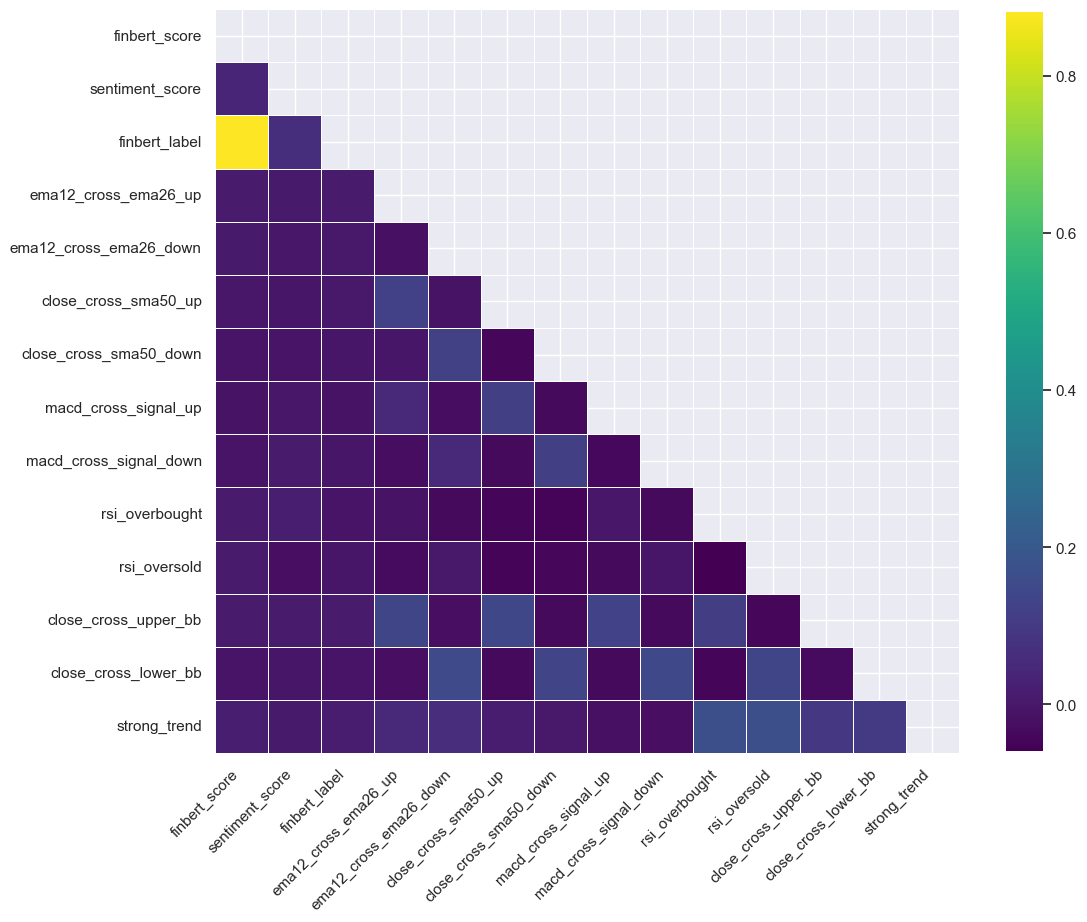

In [15]:
sns.set(font_scale=1.1)
corr_train = df_for_training.drop(columns=['decision']).corr(method="spearman")
mask = np.triu(np.ones_like(corr_train, dtype=bool))

sns.set(font_scale=1.0)
plt.figure(figsize=(12, 12))
sns.heatmap(
    corr_train,
    cmap='viridis',
    square=True,
    mask=mask,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

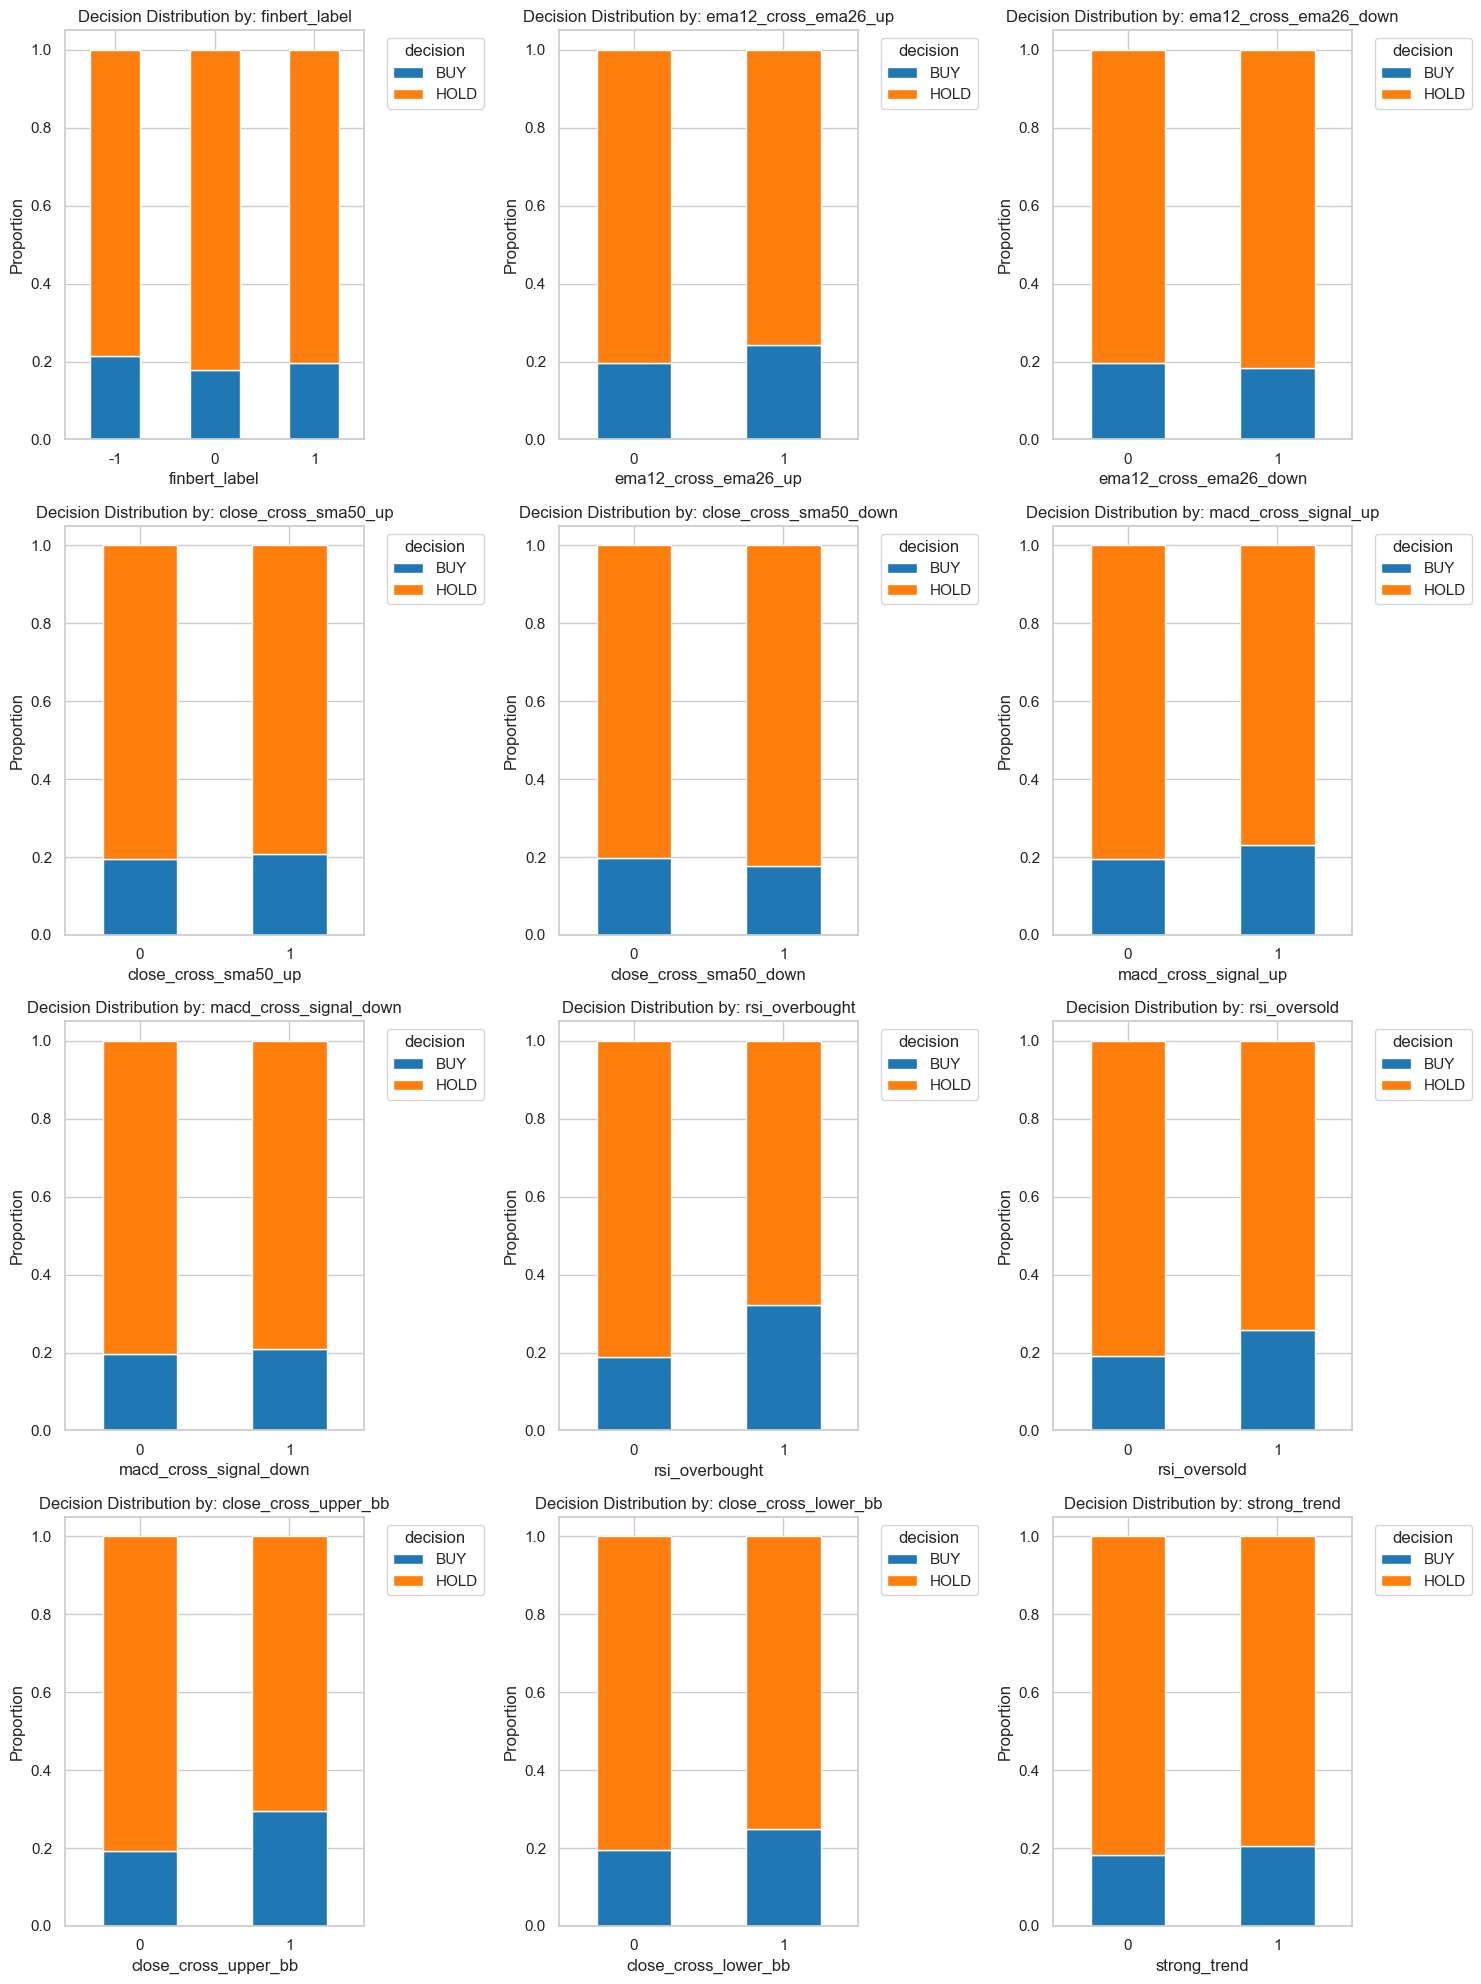

In [16]:
def visualize_contingency(df: pd.DataFrame, target_col: str, feature_cols: list):
    
    sns.set_style("whitegrid")
    
    n_features = len(feature_cols)
    if n_features == 0:
        print("Feature list is empty.")
        return

    # Determine the optimal number of rows and columns
    n_cols = 3 
    n_rows = (n_features + n_cols - 1) // n_cols 

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = axes.flatten() # Convert the 2D array of axes to 1D

    for idx, col in enumerate(feature_cols):
        if idx >= len(axes): break # Safety break if there are more plots than available spaces

        # 1. Create the contingency table and normalize
        # Normalize by row (index) - to see the distribution within each feature state
        contingency_norm = pd.crosstab(df[col], df[target_col], normalize='index')
        
        # 2. Build the Stacked Bar Plot
        contingency_norm.plot(kind='bar', stacked=True, ax=axes[idx], color=['#1f77b4', '#ff7f0e'])
        
        axes[idx].set_title(f'Decision Distribution by: {col}', fontsize=12)
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Proportion')
        axes[idx].tick_params(axis='x', rotation=0) # Remove X label rotation
        axes[idx].legend(title=target_col, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Hide unused subplots
    for i in range(n_features, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

BINARY_FEATURES = [
    feature for feature in df_for_training.columns if feature not in ['decision', 'sentiment_score', 'finbert_score']
]
visualize_contingency(df, 'decision', BINARY_FEATURES)

In [17]:
from itertools import combinations
BINARY_FEATURES = [feat for feat in df_for_training.columns if feat not in ['decision'] and df_for_training[feat].nunique() == 2]


def analyze_feature_combo(df: pd.DataFrame, feature_list: list) -> pd.DataFrame:
    """Creates a unique combination key, groups by it, and calculates the Trade Rate."""
    
    # Create a unique key (e.g., '101')
    df['combo_key'] = df[feature_list].astype(str).agg(''.join, axis=1)
    
    # Group and aggregate statistics
    analysis = df.groupby('combo_key')['decision'].agg(
        Total_Count='count', 
        Trade_Count=lambda x: (x == 'BUY').sum()  # Count of TRADE decisions
    ).reset_index()
    
    analysis['Trade_Rate'] = analysis['Trade_Count'] / analysis['Total_Count']
    analysis['Features'] = ' & '.join(feature_list)
    
    # Create human-readable description (e.g., 'rsi_overbought=ON, strong_trend=OFF')
    analysis['Combo_Description'] = analysis['combo_key'].apply(
        lambda x: ', '.join(f"{f}={'ON' if x[i]=='1' else 'OFF'}" for i, f in enumerate(feature_list))
    )
    
    # Remove temporary column
    df.drop(columns=['combo_key'], inplace=True)
    
    return analysis

# --- Analysis Execution ---

all_results = []
MIN_SUPPORT = 50  # Minimum number of observations for statistical reliability

# Iterate through combinations of length 2 and 3
for k in [2, 3]:
    # Get all possible combinations of length k
    for feature_combo in combinations(BINARY_FEATURES, k):
        # Use a copy of the DataFrame for safe key creation
        df_temp = df_for_training.copy()
        
        # Analyze and append results
        results = analyze_feature_combo(df_temp, list(feature_combo))
        results['N_Features'] = k
        all_results.append(results)

# Combine all results into one DataFrame
final_df = pd.concat(all_results, ignore_index=True)

# --- Filtering and Sorting for TOP-5 ---

# Filter by minimum support
filtered_df = final_df[final_df['Total_Count'] >= MIN_SUPPORT]

# Filter for combinations better than random chance
filtered_df = filtered_df[filtered_df['Trade_Rate'] > 0.01]

# Sort by Trade Rate (desc) and Total Count (desc)
top_20_combinations = filtered_df.sort_values(
    by=['Trade_Rate', 'Total_Count'], ascending=[False, False]
).head(20)

# --- Output Formatting ---

print("\n" + "="*80)
print(f"TOP 20 Feature Combinations (N={MIN_SUPPORT})")
print("="*80)

display_cols = [
    'N_Features', 
    'Trade_Rate', 
    'Total_Count', 
    'Features', 
    'Combo_Description'
]

# Format Trade_Rate to percentage string
top_20_combinations['Trade_Rate'] = (top_20_combinations['Trade_Rate'] * 100).round(2).astype(str) + '%'

print(top_20_combinations[display_cols].to_string(index=False))
print("="*80)


TOP 20 Feature Combinations (N=50)
 N_Features Trade_Rate  Total_Count                                                     Features                                                    Combo_Description
          3     40.48%           84         rsi_overbought & close_cross_upper_bb & strong_trend        rsi_overbought=ON, close_cross_upper_bb=OFF, strong_trend=OFF
          2     39.36%           94                                rsi_overbought & strong_trend                                  rsi_overbought=ON, strong_trend=OFF
          3     39.36%           94         ema12_cross_ema26_up & rsi_overbought & strong_trend        ema12_cross_ema26_up=OFF, rsi_overbought=ON, strong_trend=OFF
          3     39.36%           94       ema12_cross_ema26_down & rsi_overbought & strong_trend      ema12_cross_ema26_down=OFF, rsi_overbought=ON, strong_trend=OFF
          3     39.36%           94         close_cross_sma50_up & rsi_overbought & strong_trend        close_cross_sma50_up=OFF, rsi_

# Modeling

## LinearRegression

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

df_for_training_stage1 = df_for_training.copy()
X = df_for_training_stage1.drop(columns=['decision'])
y = df_for_training_stage1['decision']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced', random_state=42, max_iter=1000))
])
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100] ,
    'clf__penalty': ['l2', 'l1']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
gs.fit(x_train, y_train)

print("Best parameters:", gs.best_params_)
print("Best cross-validation AUC-ROC:", gs.best_score_)

best_model = gs.best_estimator_
y_pred = best_model.predict(x_test)
y_proba = best_model.predict_proba(x_test)[:, 1]


print("Test Set Performance:")
print("Roc-AUC:", roc_auc_score(y_test, y_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, pos_label='BUY'))
print("Recall:", recall_score(y_test, y_pred, pos_label='BUY'))
print("F1-Score:", f1_score(y_test, y_pred, pos_label='BUY'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Best parameters: {'clf__C': 0.1, 'clf__penalty': 'l2'}
Best cross-validation AUC-ROC: 0.5591240879017996
Test Set Performance:
Roc-AUC: 0.5687025023856966
Accuracy: 0.6670063694267516
Precision: 0.26403508771929823
Recall: 0.3914174252275683
F1-Score: 0.31534834992142485
Confusion Matrix:
 [[ 301  468]
 [ 839 2317]]


## CatBoost

In [19]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from catboost import CatBoostClassifier
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Prepare data (same as in your original snippet)
df_for_training_stage1 = df_for_training.copy()
X = df_for_training_stage1.drop(columns=['decision'])  # Exclude finbert_label if not needed
y = df_for_training_stage1['decision']

# Train/test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Compute class weights to handle class imbalance
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
# Convert to list in the same order as classes (CatBoost expects a list of weights)
class_weights_list = class_weights.tolist()

print("Classes (order):", classes)
print("Class weights (for CatBoost):", class_weights_list)

# Base CatBoost classifier using the sklearn-compatible API
# No scaler is used because CatBoost handles numeric features well and does not require standardization
base_clf = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=0,
    thread_count=-1
)

# Parameter grid for GridSearch (analogous to the LR grid you used)
param_grid = {
    'depth': [6],
    'learning_rate': [0.01],
    'iterations': [500],
    'l2_leaf_reg': [7],
    # you can add other params (subsample, rsm, bagging_temperature, border_count) if needed
}

# Fix class_weights in the estimator so every candidate uses the computed weights
base_clf.set_params(class_weights=class_weights_list)

# Stratified CV (same as before)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search over CatBoost hyperparameters, optimizing ROC AUC
gs = GridSearchCV(
    estimator=base_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Run grid search
gs.fit(x_train, y_train)

print("Best parameters:", gs.best_params_)
print("Best cross-validation AUC-ROC:", gs.best_score_)

# Best fitted model
best_model = gs.best_estimator_

# Predictions and predicted probabilities on the test set
y_pred = best_model.predict(x_test)
y_proba = best_model.predict_proba(x_test)[:, 1]

# Print test metrics
print("Test Set Performance:")
print("Roc-AUC:", roc_auc_score(y_test, y_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Determine positive label for precision/recall/f1 prints.
# If your positive class label is the string 'TRADE', keep that; otherwise fall back to the last class (commonly 1).
positive_label = 'BUY' if 'BUY' in classes else classes[-1]
print("Using positive label for precision/recall/f1:", positive_label)

print("Precision:", precision_score(y_test, y_pred, pos_label=positive_label))
print("Recall:", recall_score(y_test, y_pred, pos_label=positive_label))
print("F1-Score:", f1_score(y_test, y_pred, pos_label=positive_label))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classes (order): ['BUY' 'HOLD']
Class weights (for CatBoost): [2.551853055916775, 0.6218410837360374]
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'depth': 6, 'iterations': 500, 'l2_leaf_reg': 7, 'learning_rate': 0.01}
Best cross-validation AUC-ROC: 0.5754219503179161
Test Set Performance:
Roc-AUC: 0.5820677603788107
Accuracy: 0.6338853503184714
Using positive label for precision/recall/f1: BUY
Precision: 0.2465857359635812
Recall: 0.4226267880364109
F1-Score: 0.3114518447532343
Confusion Matrix:
 [[ 325  444]
 [ 993 2163]]


## Random Forest

In [20]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier 
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from joblib import dump


df_for_training_stage1 = df_for_training.iloc[:15000].copy()
X = df_for_training_stage1.drop(columns=['decision'])
y = df_for_training_stage1['decision']

# Train/test split with stratification
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

classes = np.unique(y_train)
class_weights_array = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
print("Classes (order):", classes)
print("Class weights (calculated by compute_class_weight):", class_weights_array.tolist())

base_clf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
)

param_grid = {
    'n_estimators': [800],         
    'max_depth': [None],          
    'min_samples_split': [5],             
    'min_samples_leaf': [3],           
    'max_features': [None],      
    'bootstrap': [True]                   
}

cv = StratifiedKFold(n_splits=5, shuffle=False)

gs = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    param_distributions=param_grid,
    n_iter=50,                   
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=2,
    random_state=42
)

gs.fit(x_train, y_train)

print("\n" + "="*50)
print("Grid Search Results (RandomForest):")
print("="*50)
print("Best parameters:", gs.best_params_)
print("Best cross-validation AUC-ROC:", gs.best_score_)

best_model = gs.best_estimator_

y_pred = best_model.predict(x_test)
y_proba = best_model.predict_proba(x_test)[:, 1]

positive_label = classes[-1]
if 'BUY' in classes:
    positive_label = 'BUY'
elif 'SELL' in classes:
    positive_label = 'SELL'
elif 1 in classes:
    positive_label = 1

print("\n" + "="*50)
print("Test Set Performance (RandomForest):")
print("="*50)
print(f"Used positive class (pos_label): {positive_label}")
print("Roc-AUC:", roc_auc_score(y_test, y_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, pos_label=positive_label))
print("Recall:", recall_score(y_test, y_pred, pos_label=positive_label))
print("F1-Score:", f1_score(y_test, y_pred, pos_label=positive_label))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Saving the best model and metadata
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)


timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = os.path.join(models_dir, f"random_forest_best_{timestamp}.joblib")

to_save = {
    "model": best_model,
    "classes": classes,
    "best_params": gs.best_params_,
    "cv_best_score": gs.best_score_,
    "train_datetime": timestamp
}

dump(to_save, model_filename)
print(f"Saved best model and metadata to: {model_filename}")


Classes (order): ['BUY' 'HOLD']
Class weights (calculated by compute_class_weight): [2.2667170381564037, 0.641505399337111]
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Grid Search Results (RandomForest):
Best parameters: {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': None, 'bootstrap': True}
Best cross-validation AUC-ROC: 0.6535697603272764

Test Set Performance (RandomForest):
Used positive class (pos_label): BUY
Roc-AUC: 0.6499674367277529
Accuracy: 0.7403333333333333
Precision: 0.39186691312384475
Recall: 0.3202416918429003
F1-Score: 0.35245220282626766
Confusion Matrix:
 [[ 212  450]
 [ 329 2009]]
Saved best model and metadata to: ../models\random_forest_best_20251030_185400.joblib


# Results evaluation

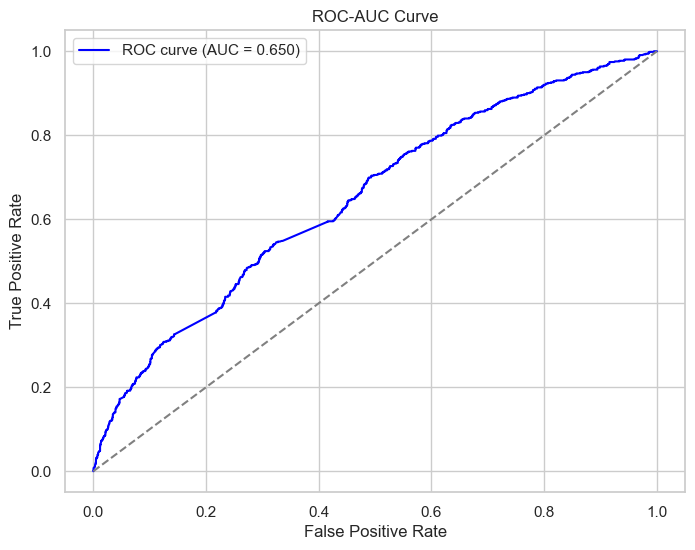

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = best_model.predict_proba(x_test)[:, 0]
y_test = y_test.map({'BUY': 1, 'HOLD': 0})
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend()
plt.grid(True)
plt.show()